In [0]:
#### 
#### Dl assignment --> 2 
##$ Pramod Yadav

In [0]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import cv2

import argparse
import os
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, TensorDataset, SequentialSampler, RandomSampler
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split


In [0]:
EPOCH = 10
BATCH_SIZE = 32
LR = 0.005         # learning rate
DOWNLOAD_MNIST = True
N_TEST_IMG = BATCH_SIZE
count = 0

In [0]:
output_2 = []
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encodedOutput = None
        self.encoder = nn.Sequential(
            nn.Linear(3*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
            #nn.Tanh(),
            #nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            #nn.Linear(3, 12),
            #nn.Tanh(),
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28*3),
            #nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        encoded = self.encoder(x)
        self.encodedOutput = encoded.detach().numpy()
        output_2.append(self.encodedOutput)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 3, 28, 28)
        return encoded, decoded


In [0]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# initialize figure
#f, a = plt.subplots(2, N_TEST_IMG, figsize=(10, 10))
#plt.ion()   # continuously plot

#fig=plt.figure(figsize=(15, 15))
r = 4
c = 4

In [0]:
Tensor = torch.FloatTensor

img_dir = '/home/pramod/planet/DL/Assign_2/faces94'

imgS_1 = glob(f"{img_dir}/**/**/*.jpg")

3059


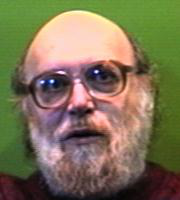

In [0]:
print(len(imgS_1))
Image.open(imgS_1[1])

In [0]:
labels = {"female" : 0, "male" : 1, "malestaff" : 2}
I2L = {0: 'female', 1: 'male', 2:'malestaff'}

In [0]:
transform_loader = transforms.Compose([transforms.RandomResizedCrop((28,28)),transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

imgS_2 = torch.stack([transform_loader(Image.open(i)) for i in imgS_1])

labels_2 = torch.tensor([labels[i.split('/')[-3]] for i in imgS_1])

trainData, testData = train_test_split(range(len(imgS_2)), test_size = 0.2, random_state = 102)

trainData_imgS = imgS_2[trainData]
trainData_labels = labels_2[trainData]

testData_imgS = imgS_2[testData]
testData_labels = labels_2[testData]

trainDataTensor = TensorDataset(trainData_imgS,trainData_labels)
testDataTensor = TensorDataset(testData_imgS,testData_labels)

trainDataSmpls = RandomSampler(trainDataTensor)
testDataSmpls = SequentialSampler(testDataTensor)

trainDataLoader = DataLoader(trainDataTensor, sampler=trainDataSmpls, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testDataTensor, sampler=testDataSmpls, batch_size=BATCH_SIZE)

print(len(testDataLoader))
print("done")

20
done


Epoch:  1 | train loss: 0.3131
Epoch:  2 | train loss: 0.1400
Epoch:  3 | train loss: 0.1190
Epoch:  4 | train loss: 0.1044
Epoch:  5 | train loss: 0.1108
Epoch:  6 | train loss: 0.0921
Epoch:  7 | train loss: 0.0998
Epoch:  8 | train loss: 0.0924
Epoch:  9 | train loss: 0.1048
Epoch:  10 | train loss: 0.0912


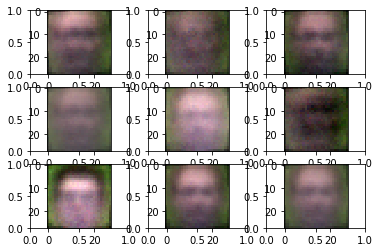

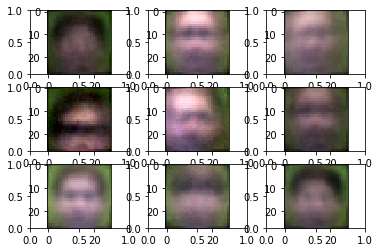

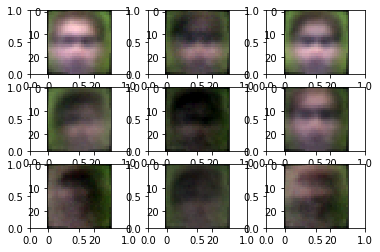

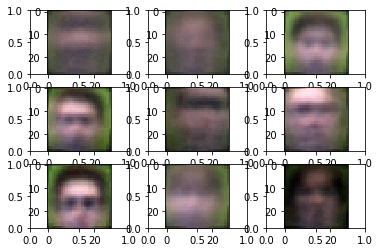

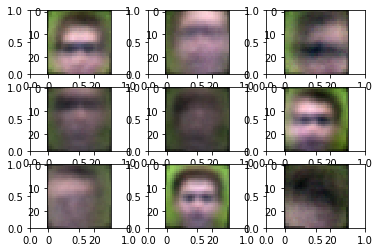

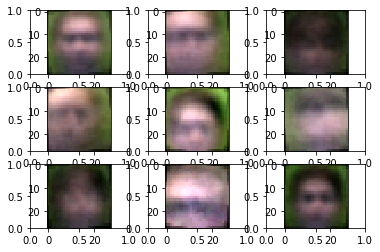

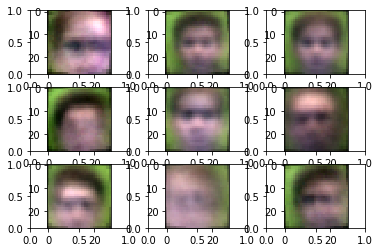

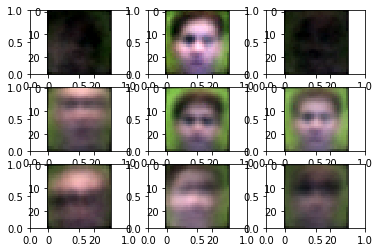

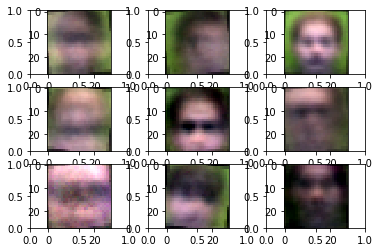

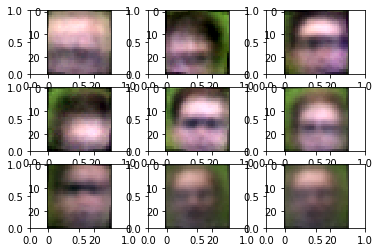

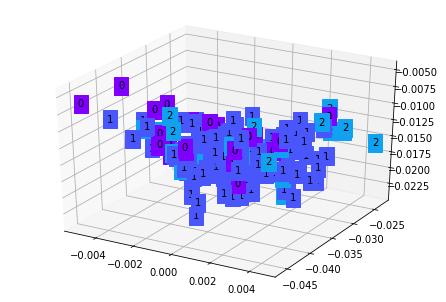

In [0]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 28, 28)
    x = x.data.numpy()
    x = np.transpose(x, axes=(0, 2, 3, 1))
    return x

p = 26

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unNorm = UnNormalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])

for epoch in range(EPOCH):
    decoded = None
    for step, (x, b_label) in enumerate(trainDataLoader):
        b_x = x.view(-1, 3, 28, 28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 3, 28, 28)   # batch y, shape (batch, 28*28)
        #print(x.shape)
        encoded, decoded = autoencoder(b_x)
        
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    
        if step % 100 == 0:
            print('Epoch: ', epoch+1, '| train loss: %.4f' % loss.data.numpy())
            #_, decoded_data = autoencoder(view_data)
    
    with torch.no_grad():
        decoded = to_img(decoded)
    
    fig, ax = plt.subplots(nrows=3, ncols=3)
    for i in range(1, 10):
        img_2 = decoded[i-1]
        #fig.add_subplot(r, c, i)
        fig.add_subplot(3,3,i)
        plt.imshow(img_2)
        s = "autoenc_e"
        s+=str(EPOCH)
        s+="_"
        s += str(epoch+1)
        #s += "_"
        #s += str(count)
    plt.draw(); 
    plt.savefig("images_2/"+s+".jpg")
    count+=1
plt.show()

            
# visualize in 3D plot
view_data = trainData_imgS[:200].view(-1, 3*28*28).type(torch.FloatTensor)/255.
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = trainData_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()


In [0]:
from tqdm import tqdm
autoencoder.eval()
with open('results.csv', 'w') as csv_file:
    for data in tqdm(trainDataLoader):
        img, label  = data
        img = img.view(img.size(0),-1)
        img = Variable(img)
        with torch.no_grad():
            _ = autoencoder(img)
        vec = autoencoder.encodedOutput
        for x,l in zip(vec, label):
            x = [str(q) + ',' for q in x]
            x = "".join(x) + I2L[l.item()] + '\n'
            csv_file.write(x)
    csv_file.close()
with open('results.csv', 'a') as csv_file:
    for data in tqdm(testDataLoader):
        img, label  = data
        img = img.view(img.size(0),-1)
        img = Variable(img)
        with torch.no_grad():
            _ = autoencoder(img)
        vec = autoencoder.encodedOutput
        for x,l in zip(vec, label):
            x = [str(q) + ',' for q in x]
            x = "".join(x) + I2L[l.item()] + '\n'
            csv_file.write(x)
    csv_file.close()

100%|██████████| 20/20 [00:00<00:00, 136.88it/s]
